#### Kaggle competition

Label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond


#### What the data looks like ? 
Train-jpg: 40K+ satelite photos <br>
train_v2: (image_name, tags) Unique tags 449 <br>
So this is a multilabel image classification problem

#### Challenge
Unlike dog and cat image recognition, the image set are very similar in colors
```terminal
nvidia-smi CUDA # monitoring
source activate tensorflow_p36
```

#### Kaggle Evaluation - F2 SCORE
F2 is used to evaluate how good the model is and has a formula given below

$F_{2} = (1+β^{2})\frac{pr}{β^{2}p+r}$


,where *p* is precision, *r* is recall and β=2 


In [1]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from scipy.stats import norm
import keras.backend as K
import numpy as np
import pandas as pd
import seaborn as sns
import math, glob, os
import operator, pickle
import cv2

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
kaggle_path = '/home/ubuntu/.kaggle/competitions/planet-understanding-the-amazon-from-space/'
# kaggle_path = '/Users/mumuxi/.kaggle/competitions/planet-understanding-the-amazon-from-space/'

def get_multitags(plot=False):
    texts = pd.read_csv(kaggle_path+'train_v2.csv').tags.tolist()
    tokenizer = Tokenizer(filters = '"(),./:~')
    tokenizer.fit_on_texts(texts)
    M  = tokenizer.texts_to_matrix(texts, mode='count')
    df = pd.DataFrame(data=M,columns=['0']+list(tokenizer.word_index.keys()))
    cols = df.columns.tolist()
    df = df[cols[-1:] + cols[1:-1]]
    if plot:
        corr = df.corr()
        fig=plt.figure(figsize=(10, 8))
        sns.heatmap(corr)
    return df

df_label = get_multitags()

In [3]:
# df_label.columns

Index(['conventional_mine', 'primary', 'clear', 'agriculture', 'road', 'water',
       'partly_cloudy', 'cultivation', 'habitation', 'haze', 'cloudy',
       'bare_ground', 'selective_logging', 'artisinal_mine', 'blooming',
       'slash_burn', 'blow_down'],
      dtype='object')

### Preprocess Image
#### 1. Calculate haze degree
Source: [Detecting Foggy Images and Estimating the Haze Degree Factor](https://www.omicsonline.org/open-access/detecting-foggy-images-and-estimating-the-haze-degree-factor-jcsb.1000226.pdf)

Define haze degree as w, where w is a number between (0,1). Smaller w indicates a clearer image while haze images have greater w.  For example, w greater than 0.7 means 80%-100% of the image area is hazed.

#### 2. Dehaze images
Source: [Single Image Haze Removal Using Dark Channel Prior](http://kaiminghe.com/publications/pami10dehaze.pdf)

The following formula is widely used to describe the formation of a haze image

$I(x) = J(x)t(x) + A(1-t(x))$

where *I* is the observed intensity, *J* represents the original haze-free image to be recovered, *A* is the global atmospheric light, and *t* is an exponential decay distribution .

The aim is to recover *J* from *I*. We can achieve that by tuning *t*, as *t* has a formula of

$t(x) = 1- w\times min[min(\frac{I_{c}(y)}{A^{c}})]$
,where *w* is weight coefficient, *c* is the dark channel color (darkest channel of RGB channel)

In [3]:
"""Single image dehazing."""
class Channel_value:
    val = -1.0
    intensity = -1.0

def find_intensity_of_atmospheric_light(img, gray,img_width=256):
    """return Atomospheric light A 
       find brightest pixels in the dark channel and find max intensity
    """
    toplist = [Channel_value()] * 2
    dark_channel = find_dark_channel(img)
    coords = np.argwhere(img[:,:,dark_channel] == np.max(img[:,:,dark_channel]) )
    I = [gray[c[0],c[1]] for c in coords]
    return max(I)

def find_dark_channel(img): #get darkest RBG channel
    return np.unravel_index(np.argmin(img), img.shape)[2]

def clamp(minimum, x, maximum):
    return max(minimum, min(x, maximum))

def dehaze_function(img, light_intensity, windowSize, t0, w,img_width=256):
    outimg = np.zeros(img.shape, img.dtype)
    for y in range(img_width):
        for x in range(img_width):
            x_low = max(x-(windowSize//2), 0)
            y_low = max(y-(windowSize//2), 0)
            x_high = min(x+(windowSize//2), img_width)
            y_high = min(y+(windowSize//2), img_width)
            sliceimg = img[y_low:y_high, x_low:x_high]
            dark_channel = find_dark_channel(sliceimg)
            t = 1.0 - (w * img.item(y, x, dark_channel) / light_intensity)
            outimg.itemset((y,x,0), clamp(0, ((img.item(y,x,0) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,1), clamp(0, ((img.item(y,x,1) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,2), clamp(0, ((img.item(y,x,2) - light_intensity) / max(t, t0) + light_intensity), 255))
    return outimg


def dehaze_image(path,w = 0.95, t0 = 0.55):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #image to gray scale
    light_intensity = find_intensity_of_atmospheric_light(img, gray)
    outimg = dehaze_function(img, light_intensity, 20, t0, w)
    return outimg

#  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def display_photo_no(image_id):
    img = cv2.imread(kaggle_path+f'train-jpg/train_{image_id}.jpg')
    plt.imshow(img)


In [4]:
miu, v, sigma = 5.1,2.9,.2461
def calculate_haziness(img_id):
    path = kaggle_path+f'train-jpg/train_{img_id}.jpg'
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #image to gray scale
    A = find_intensity_of_atmospheric_light(img, gray)
    D = img.min(2).sum()/(img.shape[0]*img.shape[1])
    B = img.max(2).sum()/(img.shape[0]*img.shape[1])
    C = B - D
    w = math.e**(-0.5*(miu*(A-D)/A+v*C/A))
    return (img_id,w,A)

def compare_photos(image_id):
    path = kaggle_path+f'train-jpg/train_{image_id}.jpg'
    fig=plt.figure(figsize=(5, 8))
    ax1 = fig.add_subplot(211)
    dehazed_img = dehaze_image(path)
    plt.imshow(dehazed_img)
    fig.add_subplot(212,sharex=ax1)
    display_photo_no(image_id)
    plt.show()

In [ ]:
# from multiprocessing import Pool
# import pickle

# res = []
# d = range(0,40479,1)
# chunks = [d[x:x+5000] for x in range(0, len(d), 5000)]
# pool = Pool(6)
# for rang in chunks:
#     print (rang)
#     res+=pool.map(calculate_haziness,rang)
# pool.close()
# pool.join()
# with open('haze_train.pkl', 'wb') as f:
#     pickle.dump(res, f)

### 1 Neural Network vanilla model

Initialise model as a sequential network. There are two basic ways of initialising a neural network, either by a sequence of layers or as a graph

#### 1.1 Load data
- opencv convert image to numpy array (256x256x3) 256 pixels 3 RBG channels
- train/test split

#### 1.2 Model Work Flow
1. **Conv2D** 
    - Images => 2 D arrays
    - Videos => Convolution 3-D 
    
    
2. **MaxPooling2D**:<br> The primary aim of a pooling operation is to reduce the size of the images. Different types of pooling operations like Min Pooling, Mean Pooling, etc. Here in MaxPooling we need the maximum value pixel from the respective region of interest.


3. **Flatten**:<br> Flattening is the process of converting all the resultant 2 dimensional arrays into a continuous vector.


4. **Dense** 
    - units: no nodes in the hidden layer
5. **Compile**
    - Optimizer:  stochastic gradient descent algorithm
    - Loss: loss function
    - Metrics: performance metric

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,BatchNormalization
from keras.initializers import glorot_normal, RandomNormal, Zeros

In [8]:
def load_train_test(train_ids,test_ids):
    read = lambda i: cv2.imread(kaggle_path+f'train-jpg/train_{i}.jpg')
    train_array = np.array(list(map(read,train_ids)))
    test_array = np.array(list(map(read,test_ids)))
    return train_array,test_array

y_train, y_test = train_test_split(df_label, test_size=0.3,random_state=1404)
X_train, X_test = load_train_test(y_train.index.tolist(),y_test.index.tolist())
print (X_test.shape,y_test.shape)

(12144, 256, 256, 3) (12144, 17)


In [9]:
def build_layers():
    model = Sequential()
    model.add(Conv2D(32, (3, 3),activation = 'relu', input_shape = (256, 256, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 2)))
    
    model.add(Conv2D(32, (3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 2)))

    model.add(Conv2D(32, (3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 2)))

    model.add(Flatten())
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(17))
    model.add(Activation('sigmoid'))
#     model.summary()
    return model

In [4]:
""" Define matrice functions """
def precision(y_true,y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true,y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
    
def F2_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return (1+4)*precision*recall/(4*precision+recall)

def build_model():
    model = build_layers()
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
                  metrics = ['accuracy',F2_score])
    return model

def train_model():
    model = build_model()
    model.fit(X_train, y_train, epochs=2, batch_size=50,validation_data=(X_test, y_test))
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss: %.3f  accuracy: %.3f F2 score: %.3f.' %(score[0],score[1],score[2]))
    return model
    

In [ ]:
model = train_model()


Train on 28335 samples, validate on 12144 samples
Epoch 1/2
28335/28335 [==============================] - 128s 5ms/step - loss: 5.9307 - acc: 0.2844 - F2_score: 0.6554 - val_loss: 5.5013 - val_acc: 0.8709 - val_F2_score: 0.5387
Epoch 2/2
28335/28335 [==============================] - 127s 4ms/step - loss: 5.0636 - acc: 0.6142 - F2_score: 0.7116 - val_loss: 5.1653 - val_acc: 0.6509 - val_F2_score: 0.6734


#### 1.3 Implementation
Build different models and test
F2 | prec  |  recall
_________________________

0.70 | 0.47 | 0.75 | model 2 Test F2: 0.754 - multi layers

0.00 | 0.00 | 0.00 | model 3 - haze free

-  Divide labels to 2 categories.
    - weather labels
    - non-weather labels
-  Run model on haze free images



### Predict weather labels 
- Predict clear,haze,partly_cloudy,cloudy tags
- Define weather_tags = \['clear','haze','partly_cloudy','cloudy'\]

We test if the weather labels are independent. In other words, if image only has 1 label from (clear,haze,partly_cloudy,cloudy)
```python
def test():
    y = df_label[weather_tags].copy()
    y.columns=[1,2,3,4]
    y['sum'] = y.sum(axis=1)
    return y[y['sum']!=1]  
```
All train images contains 1 weather label, except train_img2448.jpg has none

            water


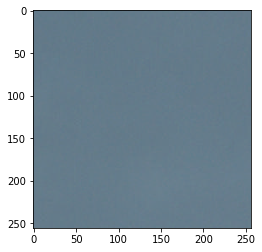

In [119]:
print ('            water')
display_photo_no(24448)

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [110]:
weather_tags = ['clear','haze','partly_cloudy','cloudy']

def load_test_train():
    df_w = pd.DataFrame(data=pickle.load(open("haze_train.pkl", "rb" )),columns=['id','w','A'])
    y = df_label[weather_tags].copy()
    y.columns=[1,2,3,4]
    y = pd.get_dummies(y).idxmax(1)
    X_train,X_test,y_train,y_test = train_test_split(df_w[['w','A']],y,stratify=y,test_size=0.3,random_state=1404)
    return X_train,X_test,y_train,y_test

def plot_confusion_matrix(y_test,y_pred):
    M = confusion_matrix(y_test,y_pred)
    M = M/M.sum(axis=1)[:,None]
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(M, annot=True,fmt='.0%',cmap="YlGnBu")
    ax.set_xticklabels(weather_tags)
    ax.set_yticklabels(weather_tags)
    plt.show()
    
X_train,X_test,y_train,y_test = load_test_train()

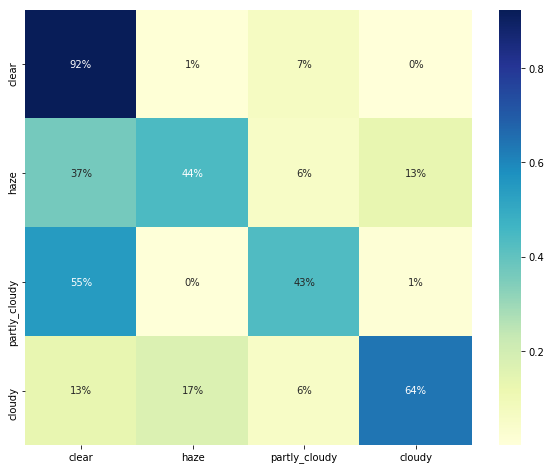

In [111]:
def multi_class_logistic():
    lgr = LogisticRegression(multi_class="multinomial",solver='newton-cg')
    lgr.fit(X_train, y_train)
    y_pred = lgr.predict(X_test)
    plot_confusion_matrix(y_test,y_pred)
    
multi_class_logistic()

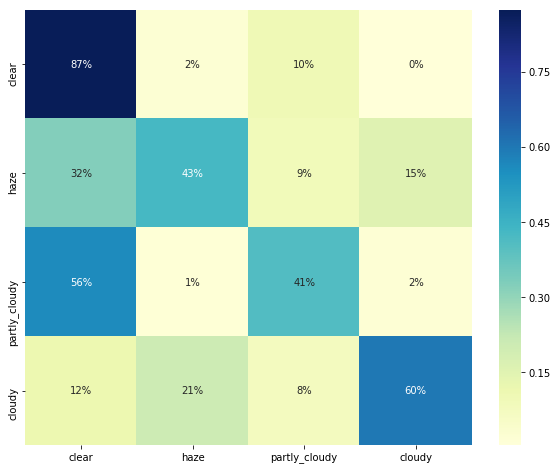

In [122]:
def random_forest():
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    plot_confusion_matrix(y_test,y_pred)
    
random_forest()


In [ ]:
df_label.head()

In [ ]:
""" Random Forest.
Implement Random Forest algorithm with TensorFlow, and apply it to classify 
handwritten digit images. This example is using the MNIST database of 
handwritten digits as training samples (http://yann.lecun.com/exdb/mnist/).
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""

from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources

# Ignore all GPUs, tf random forest does not benefit from it.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

# Parameters
num_steps = 500 # Total steps to train
batch_size = 1024 # The number of samples per batch
num_classes = 10 # The 10 digits
num_features = 784 # Each image is 28x28 pixels
num_trees = 10
max_nodes = 1000

# Input and Target data
X = tf.placeholder(tf.float32, shape=[None, num_features])
# For random forest, labels must be integers (the class id)
Y = tf.placeholder(tf.int32, shape=[None])

# Random Forest Parameters
hparams = tensor_forest.ForestHParams(num_classes=num_classes,
                                      num_features=num_features,
                                      num_trees=num_trees,
                                      max_nodes=max_nodes).fill()

# Build the Random Forest
forest_graph = tensor_forest.RandomForestGraphs(hparams)
# Get training graph and loss
train_op = forest_graph.training_graph(X, Y)
loss_op = forest_graph.training_loss(X, Y)

# Measure the accuracy
infer_op, _, _ = forest_graph.inference_graph(X)
correct_prediction = tf.equal(tf.argmax(infer_op, 1), tf.cast(Y, tf.int64))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize the variables (i.e. assign their default value) and forest resources
init_vars = tf.group(tf.global_variables_initializer(),
    resources.initialize_resources(resources.shared_resources()))

# Start TensorFlow session
sess = tf.Session()

# Run the initializer
sess.run(init_vars)

# Training
for i in range(1, num_steps + 1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    _, l = sess.run([train_op, loss_op], feed_dict={X: batch_x, Y: batch_y})
    if i % 50 == 0 or i == 1:
        acc = sess.run(accuracy_op, feed_dict={X: batch_x, Y: batch_y})
        print('Step %i, Loss: %f, Acc: %f' % (i, l, acc))

# Test Model
test_x, test_y = mnist.test.images, mnist.test.labels
print("Test Accuracy:", sess.run(accuracy_op, feed_dict={X: test_x, Y: test_y}))

In [ ]:
# def predict_test_labels(model):
#     N = 5000
#     y_pred = model.predict(X_train[0:N])
#     primary_train = y_pred[:,2]
#     primary_test = y_train['clear'][0:N].values
#     plt.scatter(primary_train,primary_test)
#     plt.show()
# predict_test_labels(model2)

In [ ]:
y_test.head()

y_pred

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
results = cross_val_score(estimator, X, y cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

#### Appendix
version 1 - single layer
```python
def build_layers():
    """32 filters of size 12x12
        input image size 256 x 256, 3 for RGB
    """
    no_features = 17
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(12,12), activation = 'relu',input_shape = (256, 256, 3)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(units = no_features, activation = 'sigmoid'))
    return model
```
